# Install Necessary Libraries

In [1]:
!pip install pandas matplotlib seaborn nltk

# Import Required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download Necessary NLTK Data

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/thens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/thens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/thens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Handle Missing Data

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('fashion_products_data.csv', low_memory=False)

# Display the missing values before cleaning (for debugging)
missing_before = df.isnull().sum().sum()
print(f"Missing values before cleaning: {missing_before}")

# Identify string columns and fill missing values with 'Unknown'
string_cols = df.select_dtypes(include=['object']).columns
df[string_cols] = df[string_cols].fillna('Unknown')  # For string columns

# Identify numerical columns and fill missing values with 0
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(0)    # For numerical columns

# Handle complex JSON-like columns
for col in df.select_dtypes(include=['object']):
    try:
        # Try parsing as JSON
        sampleValue = df[col].dropna().iloc[0]
        json.loads(sampleValue)  # Check if it's JSON
        # Assign {} or [] to fill missing JSON-like values
        df[col] = df[col].fillna('{}' if isinstance(sampleValue, dict) else '[]')
    except:
        continue

# Display missing values after cleaning
missing_after = df.isnull().sum().sum()
print(f"Missing values after cleaning: {missing_after}")

# Save cleaned DataFrame
df.to_csv('cleaned_fashion_products_data.csv', index=False)


Missing values before cleaning: 316610
Missing values after cleaning: 0


# Install SpaCy and Required Model for Text Preprocessing

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer

# Load SpaCy Language Model

In [6]:
# Load the small English model from SpaCy
nlp = spacy.load("en_core_web_sm")

# Define Text Preprocessing Function Using SpaCy

In [7]:
def preprocess_text_spacy(text):
    # Ensure the input text is a string and handle NaN or None values
    if not isinstance(text, str):
        return ''
    
    # Remove special characters and non-English words (retain alphabets and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Process text with SpaCy
    doc = nlp(text.lower())  # Convert to lowercase and process with SpaCy
    
    # Lemmatization, stopword removal, and tokenization using SpaCy
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

# Check Available Columns and Apply Preprocessing to Relevant Column

In [ ]:
# Check available columns
print("Available Columns in the DataFrame:")
print(df.columns)

if 'product_name' in df.columns:
    # Apply the text preprocessing function to the 'product_name' column
    df['product_name'] = df['product_name'].apply(preprocess_text_spacy)
    print("Preprocessing applied to 'product_name' column.")
else:
    print("'product_name' column not found. Please check the available columns.")
    print(df.columns)

Available Columns in the DataFrame:
Index(['uniq_id', 'crawl_timestamp', 'asin', 'product_url', 'product_name',
       'image_urls__small', 'medium', 'large', 'browsenode', 'brand',
       'sales_price', 'weight', 'rating', 'sales_rank_in_parent_category',
       'sales_rank_in_child_category', 'delivery_type', 'meta_keywords',
       'amazon_prime__y_or_n', 'parent___child_category__all',
       'best_seller_tag__y_or_n', 'other_items_customers_buy',
       'product_details__k_v_pairs', 'discount_percentage', 'colour',
       'no__of_reviews', 'seller_name', 'seller_id', 'left_in_stock',
       'no__of_offers', 'no__of_sellers', 'technical_details__k_v_pairs',
       'formats___editions', 'name_of_author_for_books'],
      dtype='object')
Preprocessing applied to 'product_name' column.


# Verify Preprocessing Results

In [9]:
# Show the first few rows of the DataFrame after applying preprocessing
print(df[['product_name']].head())

                                        product_name
0  la facon cotton kalamkari handblock saree blou...
1       sf jeans pantaloon men plain slim fit tshirt
2  lovista cotton gota patti tassel traditional p...
3                people men print regular fit tshirt
4  monte carlo grey solid cotton blend polo colla...


# Visualize Distribution of Key Variables

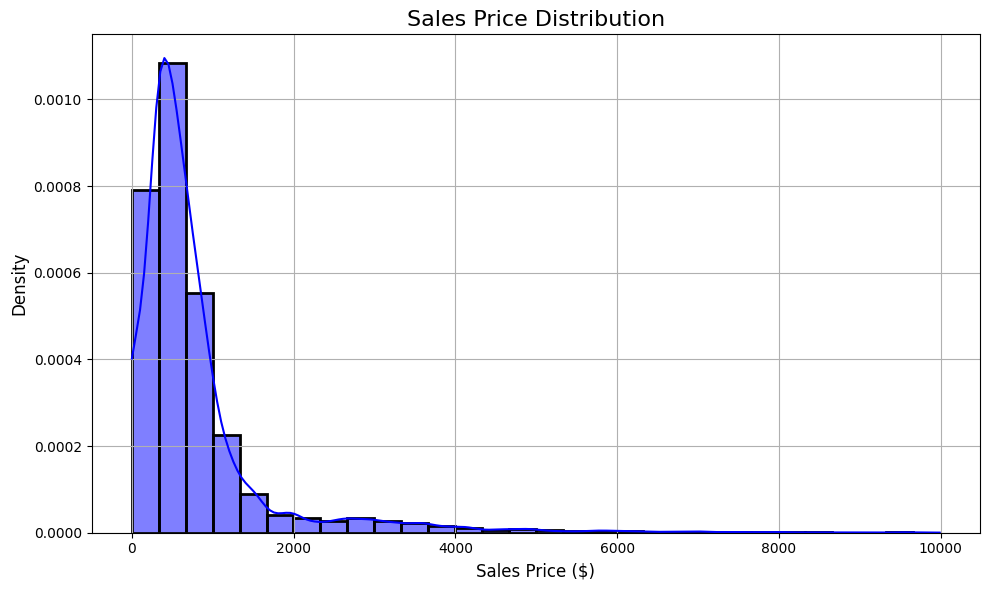

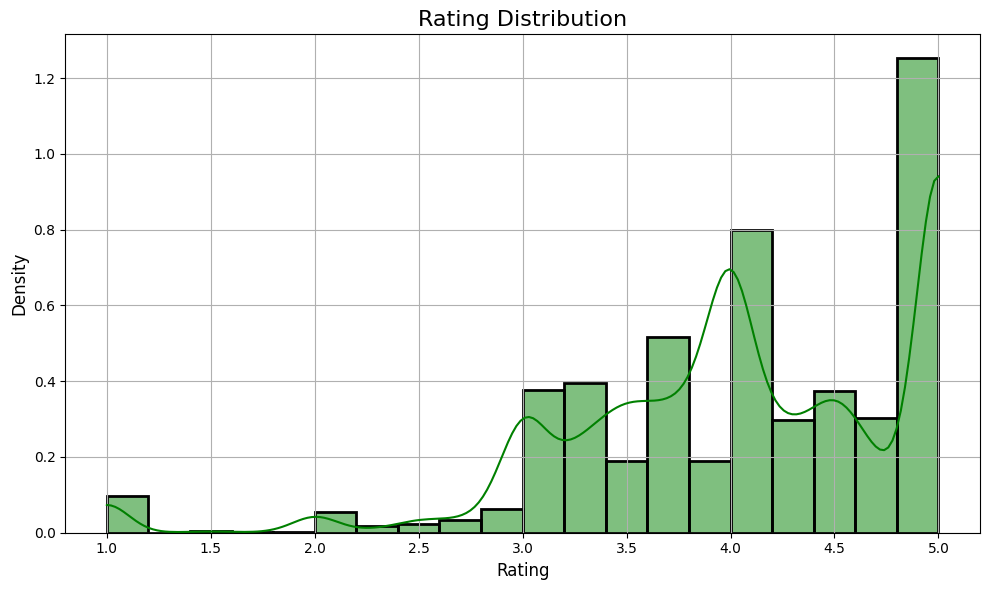

In [10]:
# Sales Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sales_price'], bins=30, kde=True, color='blue', stat='density', linewidth=2)
plt.title('Sales Price Distribution', fontsize=16)
plt.xlabel('Sales Price ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True, color='green', stat='density', linewidth=2)
plt.title('Rating Distribution', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlation Heatmap for Numerical Columns

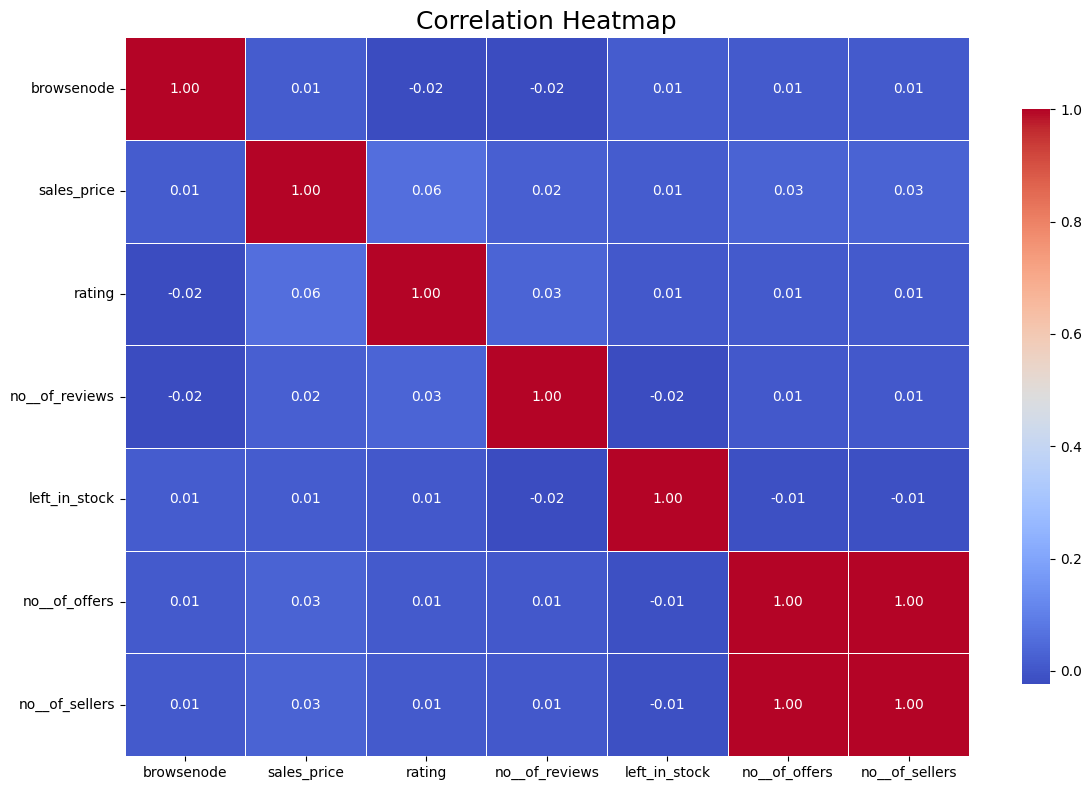

In [11]:
# Correlation Heatmap
numerical_cols = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()


# Grouping and Aggregation Analysis


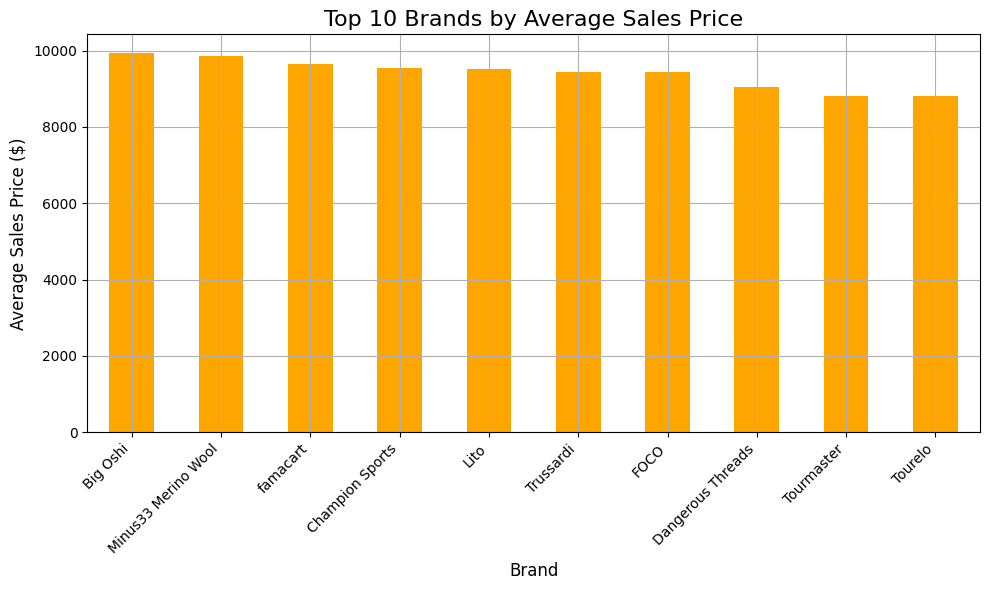

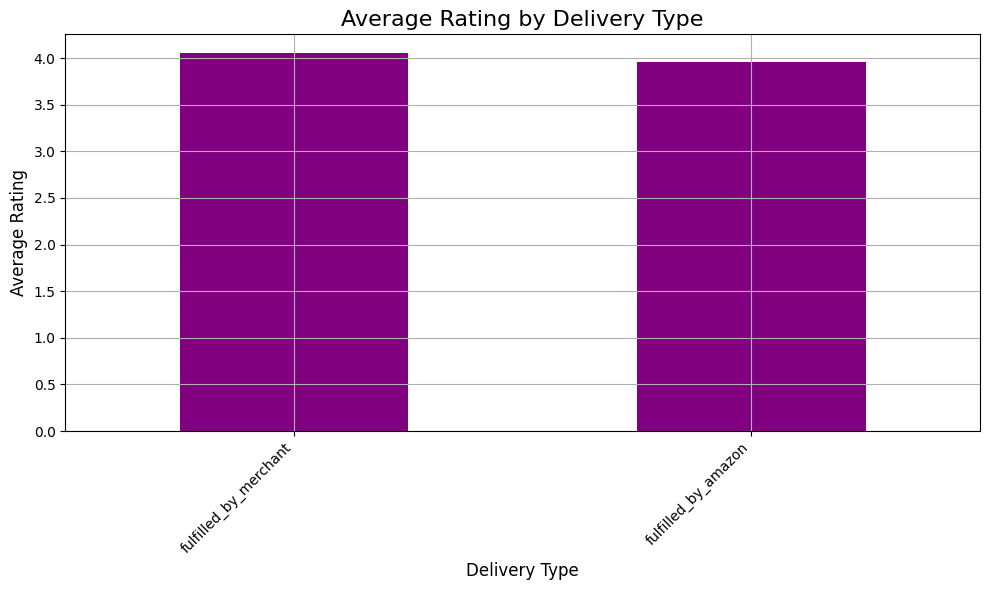

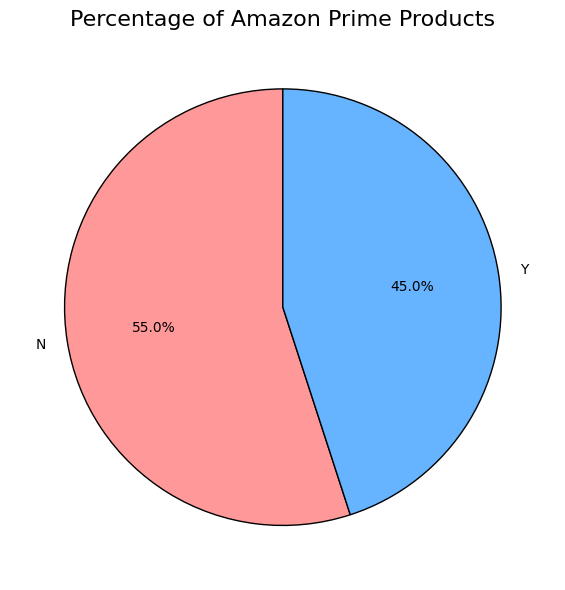

In [12]:
# Average Sales Price by Brand
avg_sales_price_by_brand = df.groupby('brand')['sales_price'].mean().sort_values(ascending=False).head(10)
avg_sales_price_by_brand.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Top 10 Brands by Average Sales Price', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Average Sales Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Average Rating by Delivery Type
avg_rating_by_delivery = df.groupby('delivery_type')['rating'].mean().sort_values(ascending=False)
avg_rating_by_delivery.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title('Average Rating by Delivery Type', fontsize=16)
plt.xlabel('Delivery Type', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Percentage of Amazon Prime Products
amazon_prime_percentage = df['amazon_prime__y_or_n'].value_counts(normalize=True) * 100
amazon_prime_percentage.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 6), colors=['#ff9999','#66b3ff'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Percentage of Amazon Prime Products', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()


# Distribution of Ratings for High-Rated Products

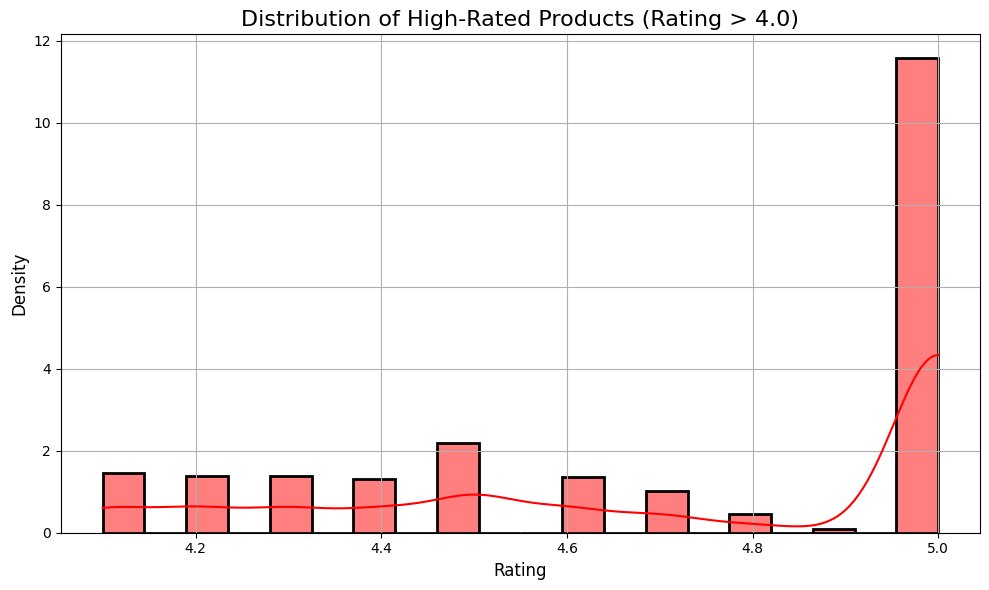

In [15]:
# Filter high-rated products
high_rated_products = df[df['rating'] > 4.0]

# Rating Distribution for High-Rated Products
plt.figure(figsize=(10, 6))
sns.histplot(high_rated_products['rating'], bins=20, kde=True, color='red', stat='density', linewidth=2)
plt.title('Distribution of High-Rated Products (Rating > 4.0)', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
